# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam,RMSprop
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

2022-12-19 10:41:32.802023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 10:41:35.008300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 10:41:35.008338: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 10:41:39.725282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

# Calculating Bollinger Bands

In [8]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [9]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [10]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [11]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Get Nasdaq 100 Tickers

In [16]:
def get_nasdaq100():
    tickers = []
    headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
    res = requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100", headers=headers)
    main_data = res.json()['data']['data']['rows']
    for company in main_data:
        tickers.append(company['symbol'])
    return tickers

# Screener Algorithm

In [13]:
def screener(company):
    calls = ''
    puts = ''
    #fails = ''
    one_day_streak = ''
    two_days_streak = ''
    three_days_streak = ''
    four_days_streak = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day ==-5:
                calls = ''
                puts = ''
                four_days_streak = ticker + ' - ' + current_status
            elif day ==-4:
                calls = ''
                puts = ''
                three_days_streak = ticker + ' - ' + current_status
            elif day ==-3:
                calls = ''
                puts = ''
                two_days_streak = ticker + ' - ' + current_status
            elif day ==-2:
                calls = ''
                puts = ''
                one_day_streak = ticker + ' - ' + current_status
            break
    return calls,puts,one_day_streak,two_days_streak,three_days_streak,four_days_streak

# Screener

In [14]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []
ones = []
twos = []
threes = []
fours = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_ones!='':
            ones.append(company_ones)
        if company_twos!='':
            twos.append(company_twos)
        if company_threes!='':
            threes.append(company_threes)
        if company_fours!='':
            fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check Nasdaq-100

In [19]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

nasdaq100 = get_nasdaq100()
for company in nasdaq100:
    stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock(company)
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

# Check S&P500

In [11]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(sp500)
#stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('CFG')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (16): ['AES', 'BKNG', 'CFG', 'CLX', 'DTE', 'HST', 'KIM', 'KMI', 'MLM', 'PCAR', 'RCL', 'SYY', 'TRGP', 'VMC', 'VRTX', 'XEL']
Puts (0): []
4-days Streak (17): ['ARE - call', 'AXP - call', 'BWA - call', 'CBRE - call', 'CME - call', 'CSX - call', 'DHI - call', 'EXPD - call', 'FMC - call', 'HLT - call', 'MAR - call', 'MKC - call', 'MS - call', 'NSC - call', 'OKE - call', 'V - call', 'WMB - call']
3-days Streak (73): ['ADBE - call', 'ADI - call', 'AFL - call', 'AKAM - call', 'ALLE - call', 'AMD - call', 'ANET - call', 'ANSS - call', 'APH - call', 'BK - call', 'BRK-B - call', 'CARR - call', 'CBOE - call', 'CDAY - call', 'CDW - call', 'CINF - call', 'CMI - call', 'CTAS - call', 'DD - call', 'DHR - call', 'DOV - call', 'DPZ - call', 'EA - call', 'EFX - call', 'EL - call', 'EMR - call', 'ENPH - call', 'FDX - call', 'FRT - call', 'GEN - call', 'GPC - call', 'GRMN - call', 'HAL - call', 'HBAN - call', 'HD - call', 'HSIC - call', 'HWM - call', 'IBM - call', 'ICE - call', 'IP - call', 'ISRG - c

# Check individual stock

In [ ]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('CFG')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

# Get pre/post market prices

In [9]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = f'{ticker} Premarket: {get_premarket_price(ticker)}'
    elif is_postmarket(current_hour):
        data = f'{ticker} Postmarket: {get_postmarket_price(ticker)}'
    else:
        data = f'{ticker} Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('CL',current_hour)

CL Not pre/post market


# Plotter

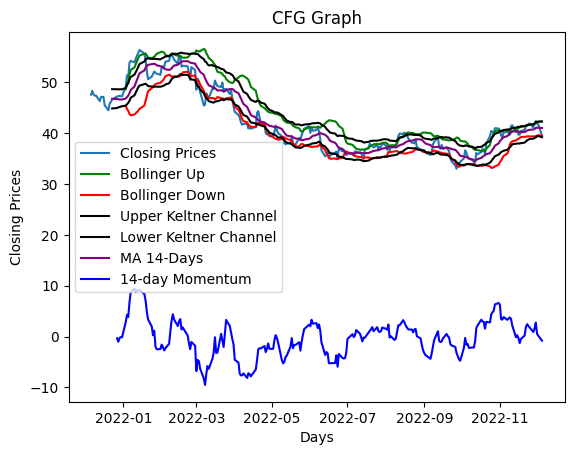

In [9]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'CFG'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()

# ML Predictions PART 1: Data Pre-Processing

In [14]:
# Step 1: Read data
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=5))
ticker = 'AMD'
data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
dataset_train = gather_data(data)
# Select features to be involved in training and prediction and target to predict
features = list(dataset_train[['open','upper_KC','lower_KC','bollinger_up','bollinger_down','MA']])#,'high','low','volume','momentum' REMOVED DUE TO NON-LINEARITY
dataset_train['3-day-close']=dataset_train['close'].shift(-3)#shift by 3 days to get the closing price 3 days later
dataset_train['3-day-roi']=((dataset_train['3-day-close']-dataset_train['open'])/dataset_train['open'])*100
target = list(dataset_train[['3-day-roi']])#target = list(dataset_train[['close']])
dataset_train.dropna(inplace=True) # THIS IS THE WORST WAY TO DEAL WITH N/A VALUES. KNN DOES NOT WORK AS FIRST VALUES ARE NaN. DOING MEDIAN
X = dataset_train[features]
y = dataset_train[target]
# Scale data
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features].values)
# Split the data for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'X_train:\n{X_train}\n\nX_test:\n{X_test}\n\ny_train:\n{y_train}\n\ny_test:\n{y_test}')

(988, 6) (248, 6) (988, 1) (248, 1)
X_train:
                open  upper_KC  lower_KC  bollinger_up  bollinger_down  \
2021-03-05  0.484033  0.666502  0.680900      0.715652        0.711991   
2021-03-03  0.626526  0.691857  0.745447      0.729584        0.752423   
2019-09-25 -0.852383 -0.833600 -0.796245     -0.847693       -0.764712   
2019-11-19 -0.564698 -0.678054 -0.641915     -0.661956       -0.680326   
2019-05-17 -0.900691 -0.893073 -0.903582     -0.917359       -0.857117   
...              ...       ...       ...           ...             ...   
2019-01-31 -1.026722 -1.063180 -1.102307     -1.066730       -1.101817   
2019-09-11 -0.828095 -0.816856 -0.792720     -0.834011       -0.769638   
2018-04-03 -1.388083 -1.351763 -1.347944     -1.330361       -1.344933   
2019-08-20 -0.812982 -0.772845 -0.810274     -0.770009       -0.797201   
2022-06-28  0.665118  0.810017  0.740688      0.950803        0.775014   

                  MA  
2021-03-05  0.659259  
2021-03-03  0.717499

/tmp/ipykernel_752662/2545131903.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features].values)


# Check for linearity

In [15]:
for feature in features:
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train[feature], dataset_train['3-day-roi'])
    print(f'At {feature}, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['volume'], dataset_train['close'])
# print(f'At volume, r_value: {r_value**2}')
# slope, intercept, r_value, p_value, std_err = stats.linregress(dataset_train['momentum'], dataset_train['close'])
# print(f'At momentum, r_value: {r_value**2}')

At open, r_value: 0.012824336916334148
At upper_KC, r_value: 0.012437480695711316
At lower_KC, r_value: 0.01212823229929595
At bollinger_up, r_value: 0.01286978498306809
At bollinger_down, r_value: 0.01313057815407481
At MA, r_value: 0.012467038129585179


Surprisingly, we see that Volume and Momentum are correlated very little to Closing prices. Only 0.010511741252537113 for volume and 0.02194343991238041 for momentum.
Remember, r_value is between 0 and 1, where 0 is bad and 1 is good

# Now plot everything to double check for linearity at those values

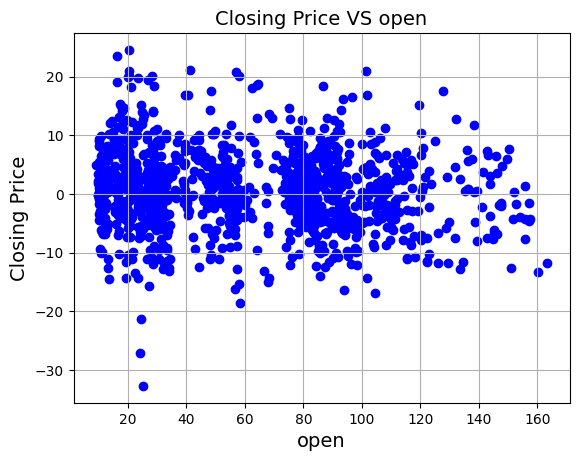

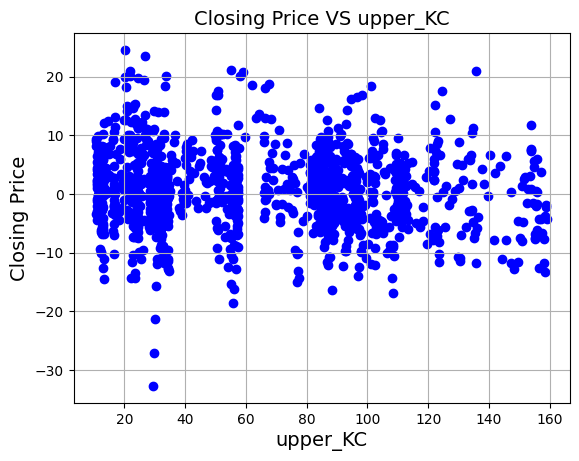

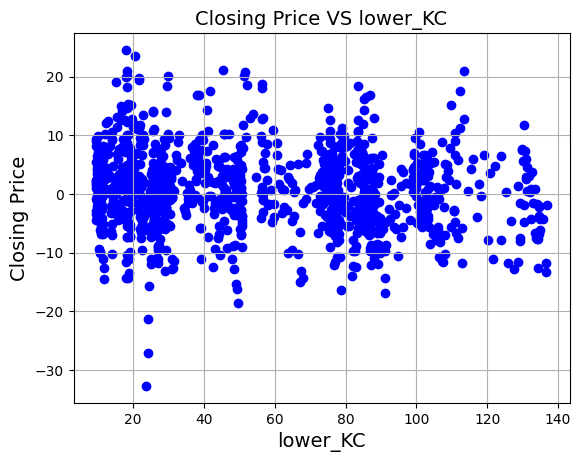

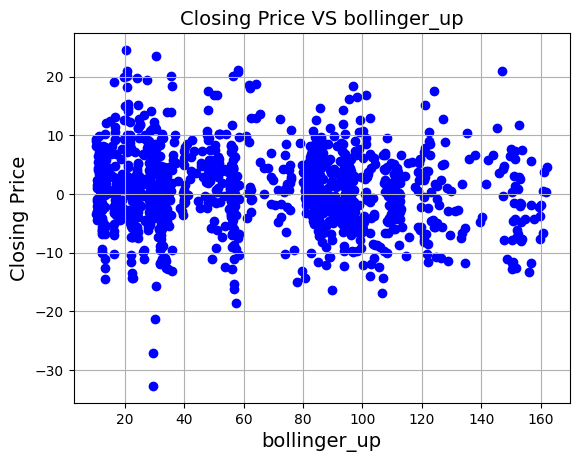

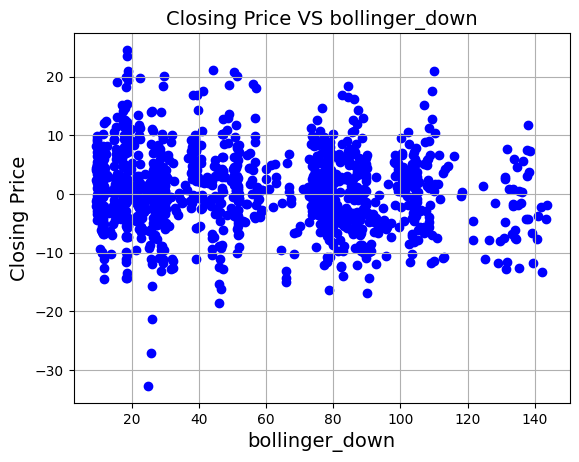

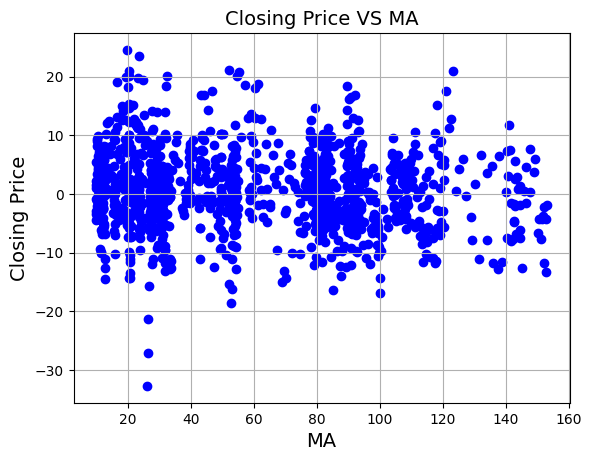

In [16]:
%matplotlib inline

for feature in features:
    plt.scatter(dataset_train[feature], dataset_train['3-day-roi'], color='blue')
    plt.title(f'Closing Price VS {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Closing Price', fontsize=14)
    plt.grid(True)
    plt.show()

# Perform Multiple Linear Regression

In [17]:
# Train model using train data:
X_train = sm.add_constant(X_train) # adding a constant

RLMmodel = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
OLSmodel = sm.OLS(y_train, X_train).fit()
print(RLMmodel.summary())
# Make predictions on test data
X_test = sm.add_constant(X_test)
predictions = RLMmodel.predict(X_test)
# for real,prediction in zip(y_test.values,predictions):
#     print(f'\nReal data: {real}. Predicted value: {prediction}')

#from sklearn.metrics import accuracy_score # THIS IS USED FOR CLASSIFIERS
print(f'r2 score: {r2_score(y_test,predictions)}')
# print(f'\nPredictions: {predictions}')
# print(f'\nActual data: {y_test}')


                    Robust linear Model Regression Results                    
Dep. Variable:              3-day-roi   No. Observations:                  988
Model:                            RLM   Df Residuals:                      981
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 08 Dec 2022                                         
Time:                        14:05:43                                         
No. Iterations:                    13                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5891      0.197      2.

In [13]:
# Let's try making a prediction
open = 113.91
keltner_up = 117.32
keltner_down = 109.53
bb_up = 115.49
bb_down = 110.9
ma = 113.2
real_data_today = scaler.transform([[open,keltner_up,keltner_down,bb_up,bb_down,ma]])
real_data_today = np.insert(real_data_today[0], 0, 1) # Add constant like in the model to add a y-int
predicted = RLMmodel.predict(real_data_today)
print(f'Price of {ticker} should go to ${predicted[0]} in 3 days')

Price of DTE should go to $114.32589719191601 in 3 days
